In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

In [2]:
mnist= fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X,y=mnist['data'],mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

### digit from the dataset

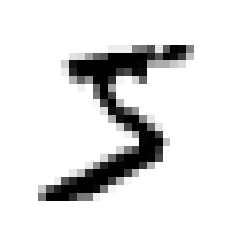

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit= X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

In [9]:
# casting y to interger since ML aglos expect numbers

In [10]:
y=y.astype(np.uint8)

In [11]:
X_train,X_test,y_train,y_test= X[:60000],X[60000:],y[:60000],y[60000:]

### Training a binary classifier, simplifying

In [12]:
y_train_5 =(y_train == 5) # True for all 5s, False otherwise
y_test_5=(y_test==5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf= SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

###  Implementing Cross-Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds= StratifiedKFold(n_splits=3, random_state=42)

for train_index,test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold= X_train[test_index]
    y_test_fold=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct= sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### classifying every image in the 'not-5' class

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1) ,dtype=bool)

In [18]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred= cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

###  precision and recall

In [21]:
from sklearn.metrics import precision_score,recall_score

In [22]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

### decision function

In [25]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold=0 #8000:false

In [29]:
y_some_digit_predict==(y_scores>threshold)

array([ True])

In [30]:
y_scores= cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [31]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

In [32]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--', label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-', label='Recall')

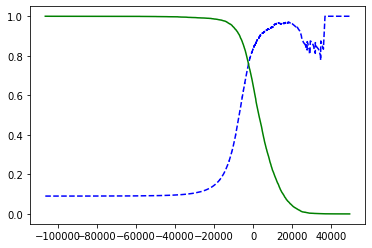

In [33]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [34]:
thresholds_90_precision= thresholds[np.argmax(precisions>=0.90)]

In [35]:
y_train_pred_90=(y_scores>=thresholds_90_precision)

In [36]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

### ROC Curve (Receiver operator Characteristic)

In [38]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds=roc_curve(y_train_5,y_scores)

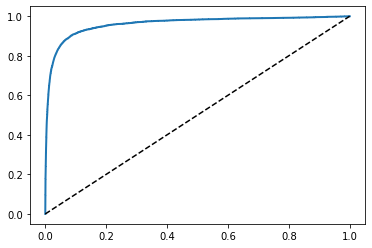

In [39]:
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') # dashed diagonal
    
plot_roc_curve(fpr,tpr)
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

### Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
forest_clf= RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5, cv=3,method="predict_proba")

In [46]:
y_scores_forest=y_probas_forest[:,1] #score=proba of positive class
fpr_forest, tpr_forest, thresholds_forest= roc_curve(y_train_5,y_scores_forest)

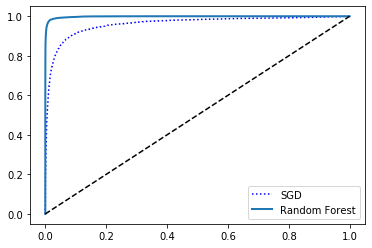

In [48]:
plt.plot(fpr,tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [49]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

### Multiclass Classification

In [ ]:
l